In [11]:
# dataset = 'cifar10', model = mobile, CELoss vs middles

from Dataloaders import dataloader_cifar10, dataloader_image_20, dataloader_ccpd

from Models import mobilenetv2, resnet
import torch
models_name = {'mobile':mobilenetv2, 'resnet':resnet}
datasets_name = {'cifar':dataloader_cifar10, 'imagenet':dataloader_image_20, 'ccpd':dataloader_ccpd}
middle_size_mobile = {x:2**x for x in range(5)}
middle_size_resnet = {x:2**x for x in range(6)}
middles_size = {'mobile':middle_size_mobile, 'resnet':middle_size_resnet}

quantization = False
int_trans = False


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [00:00<00:00, 164.90it/s]


Original Accuracy 0.8284


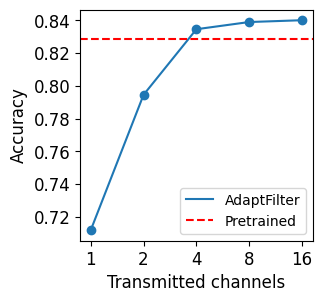

In [12]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
from tqdm import tqdm
device = 'cuda:0'
width = 16
height = 16
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    for i in range(len(middle_models)):
        middle = middle_models[i]
        gate  = gate_models[i]
        for j, (data, target) in enumerate(tqdm(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle.in_layer(out)
            out = float_to_uint(out)
            out = uint_to_float(out)
            out = middle.out_layer(out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.max(dim=1)[1]
            out = out == target
            gate_results[i].append(out.cpu().numpy())
    
    # get the conf for the server
    original_accuracy = 0
    for j, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        original_accuracy += out.cpu().numpy()
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


gate_results = np.array(gate_results)
gate_results = gate_results.reshape(gate_results.shape[0], -1)
gate_results = np.average(gate_results, axis=1)
original_accuracy = original_accuracy / len(test.dataset)
original_accuracy = original_accuracy.sum()
print('Original Accuracy', original_accuracy)

plt.figure(figsize=(3, 3))
plt.plot([str(x/32) for x in middle_size_mobile.values()], gate_results,label='AdaptFilter', marker='o')
# plot the average accuracy
plt.axhline(y=original_accuracy, color='r', linestyle='--',label='Pretrained')
# plt.title('MobileNetV2 CIFAR-10 Accuracy')
# plt.xlabel('Gate (Number of channels transmitted)')
plt.xlabel('Transmitted percentage', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('./Plots/mobile_cifar_middle_acc.pdf')
plt.show()

100%|██████████| 51/51 [00:17<00:00,  2.93it/s]

Original Accuracy 0.8647532927068999


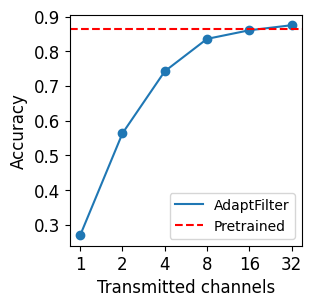

In [13]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
from Models import mobilenetv2, resnet
from Dataloaders import dataloader_cifar10, dataloader_image_20, dataloader_ccpd
from tqdm import tqdm
device = 'cuda:0'
width = 16
height = 16
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    for i in range(len(middle_models)):
        middle = middle_models[i]
        gate  = gate_models[i]
        for j, (data, target) in enumerate(tqdm(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle.in_layer(out)
            out = float_to_uint(out)
            out = uint_to_float(out)
            out = middle.out_layer(out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.max(dim=1)[1]
            out = out == target
            gate_results[i].append(np.sum(out.cpu().numpy()))
    
    # get the conf for the server
    original_accuracy = 0
    for j, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        original_accuracy += np.sum(out.cpu().numpy())
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gate_results = np.array(gate_results)
gate_results = gate_results / len(test.dataset)
gate_results = gate_results.sum(axis=1)
original_accuracy = original_accuracy / len(test.dataset)
print('Original Accuracy', original_accuracy)

plt.figure(figsize=(3, 3))
plt.plot([str(x) for x in middle_size_resnet.values()], gate_results,label='AdaptFilter')
# plat a star for each point
plt.scatter([str(x) for x in middle_size_resnet.values()], gate_results)
# plot the average accuracy
plt.axhline(y=original_accuracy, color='r', linestyle='--',label='Pretrained')
# plt.title('MobileNetV2 CIFAR-10 Accuracy')
# plt.xlabel('Gate (Number of channels transmitted)')
plt.xlabel('Transmitted channels', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('./Plots/resnet_imagenet_middle_acc.pdf')
plt.show()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:43<00:00, 228.57it/s]


Accuracy: [0.7362]


100%|██████████| 10000/10000 [00:44<00:00, 223.51it/s]


Accuracy: [0.7945]


100%|██████████| 10000/10000 [00:47<00:00, 211.68it/s]


Accuracy: [0.831]


100%|██████████| 10000/10000 [00:52<00:00, 190.74it/s]

Accuracy: [0.8356]


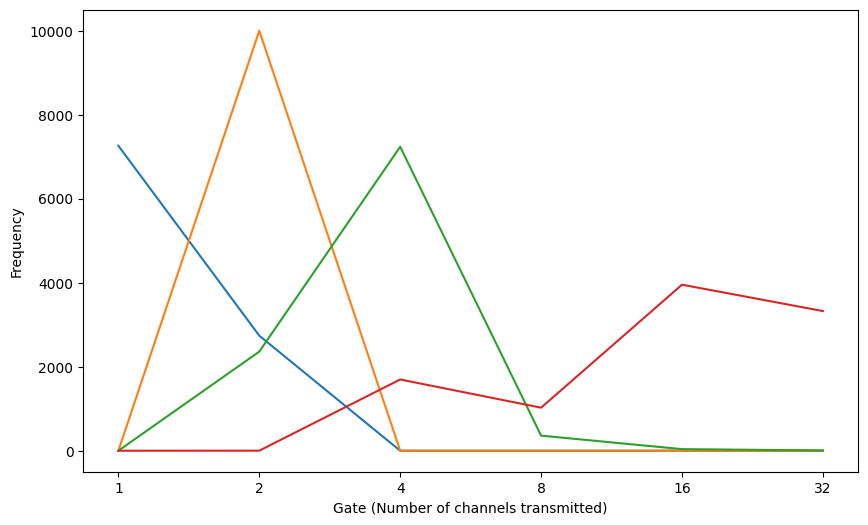

In [14]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.9
threshold = [0.75, 0.8, 0.85, 0.9]
model = 'mobile'
dataset = 'cifar-10'
mobile_cifar_gate_frequency = {'mobile_cifar_gate_frequency_075':np.zeros(len(middle_size_mobile)+1),
                                  'mobile_cifar_gate_frequency_080':np.zeros(len(middle_size_mobile)+1),
                                  'mobile_cifar_gate_frequency_085':np.zeros(len(middle_size_mobile)+1),
                                  'mobile_cifar_gate_frequency_090':np.zeros(len(middle_size_mobile)+1)}
mobile_cifar_gate_accuracy = {'mobile_cifar_gate_accuracy_075':0,
                                 'mobile_cifar_gate_accuracy_080':0,
                                 'mobile_cifar_gate_accuracy_085':0,
                                 'mobile_cifar_gate_accuracy_090':0}

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    plt.figure(figsize=(10, 6))
    for confidence in threshold:
        freq_key = 'mobile_cifar_gate_frequency_0'+str(int(confidence*100))
        acc_key = 'mobile_cifar_gate_accuracy_0'+str(int(confidence*100))
        for i, (data, target) in enumerate(tqdm(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            exit_flag = False
            for j in range(len(gate_models)):
                middle_out = middle_models[j].in_layer(out)
                gate_out = gate_models[j](middle_out)
                if gate_out>confidence:
                    mobile_cifar_gate_frequency[freq_key][j] += 1
                    middle_out = float_to_uint(middle_out)
                    middle_out = uint_to_float(middle_out)
                    out = middle_models[j].out_layer(middle_out)

                    exit_flag = True
                    break
            if not exit_flag:
                mobile_cifar_gate_frequency[freq_key][-1] += 1
                out = float_to_uint(out)
                out = uint_to_float(out)

            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.max(dim=1)[1]
            out = out == target
            mobile_cifar_gate_accuracy[acc_key] += out.cpu().numpy()
        
        # get the conf for the server
        # plot gate frequency
        
        plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency[freq_key])
        plt.xlabel('Gate (Number of channels transmitted)')
        plt.ylabel('Frequency')
        print('Accuracy:',  mobile_cifar_gate_accuracy[acc_key]/len(test))
    plt.show()

{'mobile_cifar_gate_frequency_075': array([7261., 2739.,    0.,    0.,    0.,    0.]), 'mobile_cifar_gate_frequency_080': array([    0., 10000.,     0.,     0.,     0.,     0.]), 'mobile_cifar_gate_frequency_085': array([0.000e+00, 2.360e+03, 7.237e+03, 3.590e+02, 3.800e+01, 6.000e+00]), 'mobile_cifar_gate_frequency_090': array([0.000e+00, 1.000e+00, 1.696e+03, 1.025e+03, 3.953e+03, 3.325e+03])}


TypeError: must be real number, not list

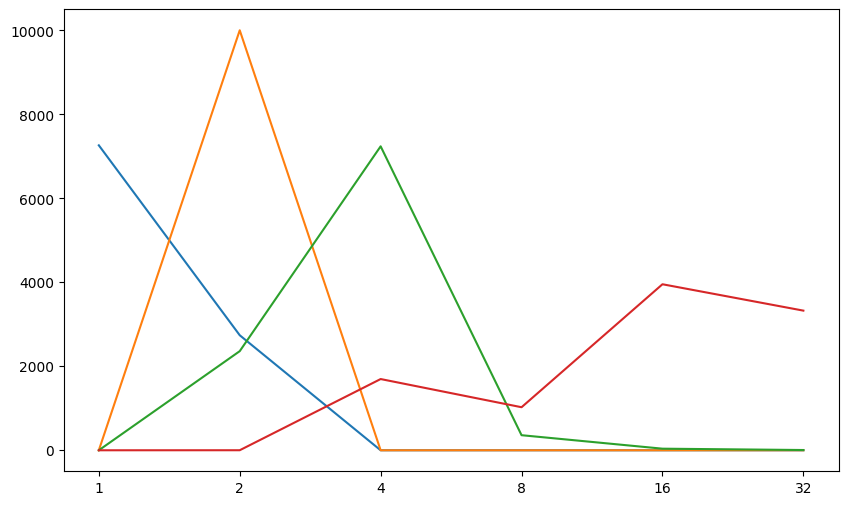

In [15]:
# plot a single image
plt.figure(figsize=(10, 6))
print(mobile_cifar_gate_frequency)
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], 
         mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_075'], label='th=0.75')
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], 
         mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_080'], label='th=0.80')
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], 
         mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_085'], label='th=0.85')
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], 
         mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_090'], label='th=0.90')

plt.title('MobileNetV2 CIFAR-10 Gate Frequency vs Thredshold - %.2f thredshold'%threshold)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# chagne 0-10000 to 0-1
plt.yticks(np.arange(0, 10001, 1000), [str(x*10)+'%' for x in range(11)])
plt.legend()
plt.show()


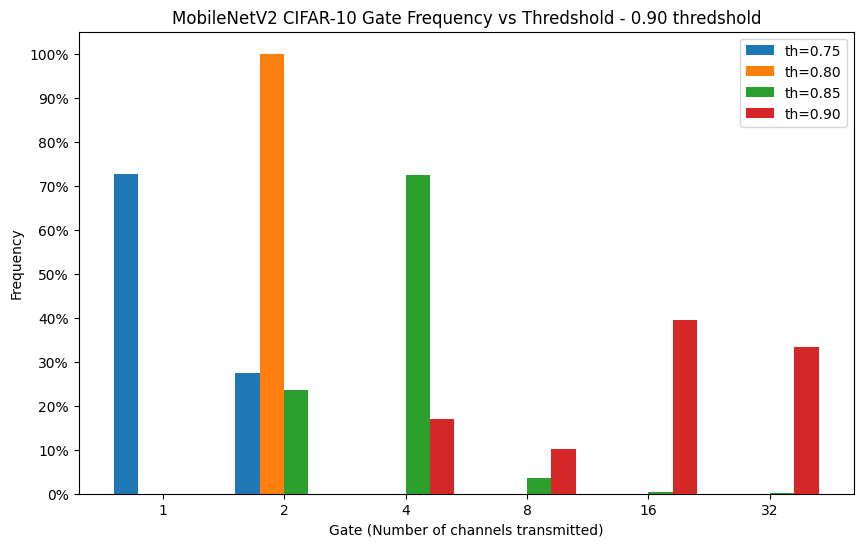

In [ ]:
# plot a single image
plt.figure(figsize=(10, 6))
plt.bar([x-0.3 for x in range(len(middle_size_mobile.values())+1)], 
        mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_075'], label='th=0.75', width=0.2)
plt.bar([x-0.1 for x in range(len(middle_size_mobile.values())+1)], 
        mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_080'], label='th=0.80', width=0.2)
plt.bar([x+0.1 for x in range(len(middle_size_mobile.values())+1)], 
        mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_085'], label='th=0.85', width=0.2)
plt.bar([x+0.3 for x in range(len(middle_size_mobile.values())+1)], 
        mobile_cifar_gate_frequency['mobile_cifar_gate_frequency_090'], label='th=0.90', width=0.2)

plt.title('MobileNetV2 CIFAR-10 Gate Frequency vs Thredshold - %.2f thredshold'%threshold)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# chagne 0-10000 to 0-1
plt.yticks(np.arange(0, 10001, 1000), [str(x*10)+'%' for x in range(11)])
plt.xticks(np.arange(len(middle_size_mobile.values())+1), [str(x) for x in middle_size_mobile.values()] + [str(2*list(middle_size_mobile.values())[-1])])
plt.legend()
plt.show()

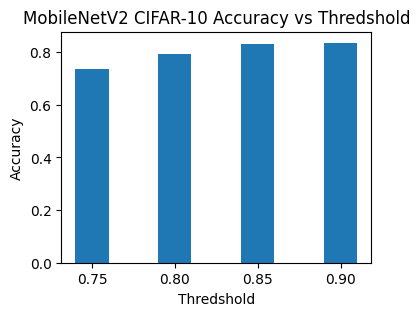

In [ ]:
# Accu with thredshold
plt.figure(figsize=(4,3))
# bar 

bar_keys = [str(x) for x in range(4)]
bar_values = [mobile_cifar_gate_accuracy['mobile_cifar_gate_accuracy_075'][0]/len(test), 
              mobile_cifar_gate_accuracy['mobile_cifar_gate_accuracy_080'][0]/len(test), 
              mobile_cifar_gate_accuracy['mobile_cifar_gate_accuracy_085'][0]/len(test), 
              mobile_cifar_gate_accuracy['mobile_cifar_gate_accuracy_090'][0]/len(test)]

plt.bar(bar_keys, bar_values, width=0.4)

plt.title('MobileNetV2 CIFAR-10 Accuracy vs Thredshold')
plt.xlabel('Thredshold')
plt.xticks(np.arange(4), ['0.75', '0.80', '0.85', '0.90'])
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 56
height = 56
threshold = [0.75, 0.8, 0.85, 0.9]
model = 'resnet'
dataset = 'imagenet'
resnet_imagenet_gate_frequency = {'resnet_imagenet_gate_frequency_075':np.zeros(len(middle_size_resnet)+1),
                                  'resnet_imagenet_gate_frequency_080':np.zeros(len(middle_size_resnet)+1),
                                  'resnet_imagenet_gate_frequency_085':np.zeros(len(middle_size_resnet)+1),
                                  'resnet_imagenet_gate_frequency_090':np.zeros(len(middle_size_resnet)+1)}
resnet_imagenet_gate_accuracy = {'resnet_imagenet_gate_accuracy_075':0,
                                 'resnet_imagenet_gate_accuracy_080':0,
                                 'resnet_imagenet_gate_accuracy_085':0,
                                 'resnet_imagenet_gate_accuracy_090':0}

client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np

with torch.no_grad():
    for confidence in threshold:
        freq_key = 'resnet_imagenet_gate_frequency_0'+str(int(confidence*100))
        acc_key = 'resnet_imagenet_gate_accuracy_0'+str(int(confidence*100))
        # get the conf for each middles
        for i, (data, target) in enumerate(tqdm(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            exit_flag = False
            for j in range(len(gate_models)):
                middle_out = middle_models[j].in_layer(out)
                gate_out = gate_models[j](middle_out)
                if gate_out>confidence:
                    resnet_imagenet_gate_frequency[freq_key][j] += 1
                    middle_out = float_to_uint(middle_out)
                    middle_out = uint_to_float(middle_out)
                    out = middle_models[j].out_layer(middle_out)

                    exit_flag = True
                    break
            if not exit_flag:
                resnet_imagenet_gate_frequency[freq_key][-1] += 1
                out = float_to_uint(out)
                out = uint_to_float(out)

            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.max(dim=1)[1]
            out = out == target
            resnet_imagenet_gate_accuracy[acc_key] += out.cpu().numpy()
        
            # get the conf for the server
            # plot gate frequency
            plt.figure(figsize=(10, 6))
            plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency[freq_key])
            # plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
            plt.xlabel('Gate (Number of channels transmitted)')
            plt.ylabel('Frequency')
            # plot accuracy
            print('Accuracy:', resnet_imagenet_gate_accuracy[acc_key]/len(test)) 
    plt.show()

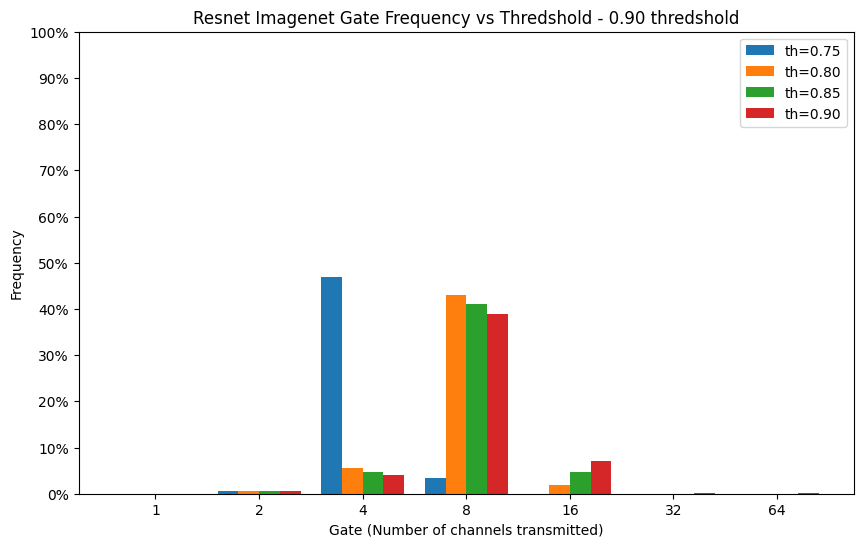

In [ ]:
# plot a single image
plt.figure(figsize=(10, 6))
plt.bar([x-0.3 for x in range(len(middle_size_resnet.values())+1)], 
        resnet_imagenet_gate_frequency['resnet_imagenet_gate_frequency_075'], label='th=0.75', width=0.2)
plt.bar([x-0.1 for x in range(len(middle_size_resnet.values())+1)], 
        resnet_imagenet_gate_frequency['resnet_imagenet_gate_frequency_080'], label='th=0.80', width=0.2)
plt.bar([x+0.1 for x in range(len(middle_size_resnet.values())+1)], 
        resnet_imagenet_gate_frequency['resnet_imagenet_gate_frequency_085'], label='th=0.85', width=0.2)
plt.bar([x+0.3 for x in range(len(middle_size_resnet.values())+1)], 
        resnet_imagenet_gate_frequency['resnet_imagenet_gate_frequency_090'], label='th=0.90', width=0.2)

plt.title('Resnet Imagenet Gate Frequency vs Thredshold - %.2f thredshold'%threshold)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# chagne 0-10000 to 0-1
plt.yticks(np.arange(0, 10001, 1000), [str(x*10)+'%' for x in range(11)])

plt.xticks(np.arange(len(middle_size_resnet.values())+1), [str(x) for x in middle_size_resnet.values()]+ [str(2*list(middle_size_resnet.values())[-1])])
plt.legend()
plt.show()

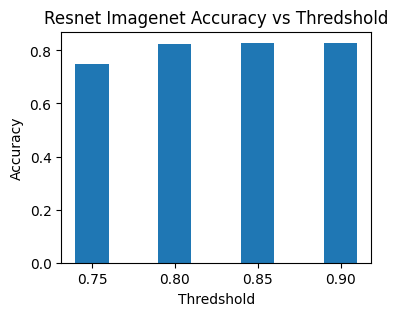

In [ ]:
# Accu with thredshold
plt.figure(figsize=(4,3))
# bar 

bar_keys = [str(x) for x in range(4)]
bar_values = [resnet_imagenet_gate_accuracy['resnet_imagenet_gate_accuracy_075'][0]/len(test), 
              resnet_imagenet_gate_accuracy['resnet_imagenet_gate_accuracy_080'][0]/len(test), 
              resnet_imagenet_gate_accuracy['resnet_imagenet_gate_accuracy_085'][0]/len(test), 
              resnet_imagenet_gate_accuracy['resnet_imagenet_gate_accuracy_090'][0]/len(test)]

plt.bar(bar_keys, bar_values, width=0.4)

plt.title('Resnet Imagenet Accuracy vs Thredshold')
plt.xlabel('Thredshold')
plt.xticks(np.arange(4), ['0.75', '0.80', '0.85', '0.90'])
plt.ylabel('Accuracy')
plt.show()

Files already downloaded and verified
Files already downloaded and verified


 10%|█         | 1000/10000 [00:05<00:48, 186.12it/s]


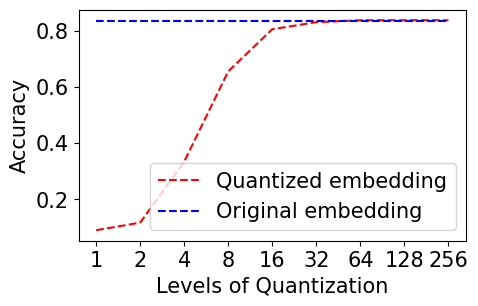

In [ ]:
# change the data type

# dataset = 'cifar10', model = mobile, accuracy vs data type
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
from Models import mobilenetv2
from Dataloaders import dataloader_cifar10
# get the number of zeros and positions
norm_acc = []
orig_acc = []

amp_list = [x for x in range(9)]

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')
client = client.eval()
server = server.eval()
client.to(device)
server.to(device)

accuracy = [0] * len(amp_list)
orig_acc = 0

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    for j in range (len(amp_list)):

        client_out = client(data).detach() # 1, c', h, w

        amp = 2**j

        client_out_max = torch.max(client_out)
        client_out_min = torch.min(client_out)
        client_out = (client_out-client_out_min)/(client_out_max-client_out_min)
        client_out = client_out*amp
        # change it to int
        client_out = client_out.long()

        client_out = client_out.float()/amp
        client_out = client_out*(client_out_max-client_out_min)+client_out_min

        pred = server(client_out).detach()
        pred = torch.argmax(pred, dim=1)
        pred_acc = torch.sum(pred == label).item()
        accuracy[j] += pred_acc
    
    if i == 1000:
        break

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    client_out = client(data).detach() # 1, c', h, w

    pred = server(client_out).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()
    orig_acc += pred_acc

    if i == 1000:
        break
plt.figure(figsize=(5,3))
for i in range(len(amp_list)):
    accuracy[i] = accuracy[i]/1000
plt.plot(amp_list, accuracy, 'r--', label='Quantized embedding')
plt.plot(amp_list, [orig_acc/1000]*len(amp_list), 'b--', label='Original embedding')
plt.xticks(amp_list, [2**x for x in amp_list], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Levels of Quantization',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=15)
# plt.title('Normalized and Original Different Amplitude: mobile cifar-10')
plt.savefig('./Plots/mobile_cifar-10_quant.pdf')
# plt.show()
# we can choose 64 and 128

 20%|█▉        | 1000/5087 [00:08<00:33, 122.04it/s]


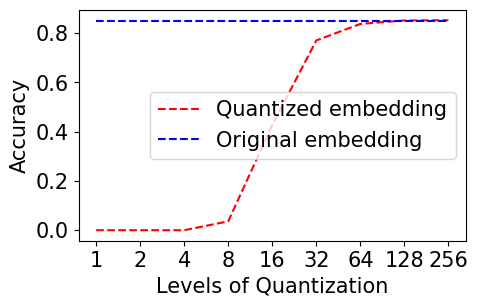

In [ ]:
# change the data type

# dataset = 'cifar10', model = mobile, accuracy vs data type
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
from Dataloaders import dataloader_image_20
from Models import resnet
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
# get the number of zeros and positions
norm_acc = []
orig_acc = []
device = 'cuda:0'

amp_list = [x for x in range(9)]

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)
client = client.eval()
server = server.eval()
client.to(device)
server.to(device)

accuracy = [0] * len(amp_list)
orig_acc = 0

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    for j in range (len(amp_list)):

        client_out = client(data).detach() # 1, c', h, w

        amp = 2**j

        client_out_max = torch.max(client_out)
        client_out_min = torch.min(client_out)
        client_out = (client_out-client_out_min)/(client_out_max-client_out_min)
        client_out = client_out*amp
        # change it to int
        client_out = client_out.long()

        client_out = client_out.float()/amp
        client_out = client_out*(client_out_max-client_out_min)+client_out_min

        pred = server(client_out).detach()
        pred = torch.argmax(pred, dim=1)
        pred_acc = torch.sum(pred == label).item()
        accuracy[j] += pred_acc
    
    if i == 1000:
        break

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    client_out = client(data).detach() # 1, c', h, w

    pred = server(client_out).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()
    orig_acc += pred_acc

    if i == 1000:
        break
plt.figure(figsize=(5,3))
for i in range(len(amp_list)):
    accuracy[i] = accuracy[i]/1000
plt.plot(amp_list, accuracy, 'r--', label='Quantized embedding')
plt.plot(amp_list, [orig_acc/1000]*len(amp_list), 'b--', label='Original embedding')
plt.xticks(amp_list, [2**x for x in amp_list], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Levels of Quantization',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=15)
# plt.title('Normalized and Original Different Amplitude: Resnet Imagenet')
# plt.show()
plt.savefig('./Plots/resnet_imagenet_quant.pdf')
# we can choose 64 and 128

  0%|          | 0/5087 [00:00<?, ?it/s]/tmp/ipykernel_3486555/2286707905.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  resnet_imagenet_gate_pred[j] += out.cpu().numpy()
100%|██████████| 5087/5087 [04:52<00:00, 17.40it/s]


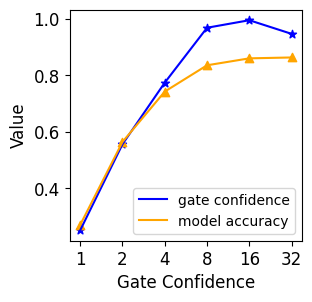

In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 56
height = 56
model = 'resnet'
dataset = 'imagenet'
import numpy as np
resnet_imagenet_gate_conf = np.zeros(len(middle_size_resnet))
resnet_imagenet_gate_pred = np.zeros(len(middle_size_resnet))

client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        client_out = client(data).detach()
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(client_out)
            gate_out = gate_models[j](middle_out)
            middle_out = float_to_uint(middle_out)
            middle_out = uint_to_float(middle_out)
            out = middle_models[j].out_layer(middle_out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.max(dim=1)[1]
            out = out == target
            resnet_imagenet_gate_conf[j] += gate_out
            resnet_imagenet_gate_pred[j] += out.cpu().numpy()
    
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(3, 3))
resnet_imagenet_gate_conf /= len(test)
resnet_imagenet_gate_pred /= len(test)
plt.plot([str(x) for x in middle_size_resnet.values()], resnet_imagenet_gate_conf, label='gate confidence', color='b')
plt.scatter([str(x) for x in middle_size_resnet.values()], resnet_imagenet_gate_conf, color='b', marker='*')
plt.plot([str(x) for x in middle_size_resnet.values()], resnet_imagenet_gate_pred, label='model accuracy', color='orange')
plt.scatter([str(x) for x in middle_size_resnet.values()], resnet_imagenet_gate_pred, color='orange', marker='^')
# plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('# Gate', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(np.arange(len(middle_size_resnet.values())), [str(x) for x in middle_size_resnet.values()])
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('./Plots/resnet_imagenet_gate_acc_vs_conf.pdf')
# plot accuracy
plt.show()

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_2124319/3022333935.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mobile_cifar_gate_pred[j] += out.cpu().numpy()
100%|██████████| 10000/10000 [03:11<00:00, 52.11it/s]


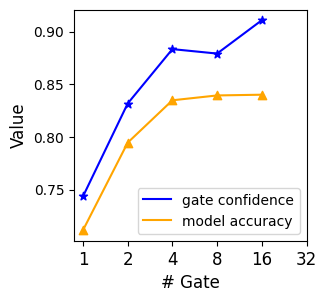

In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
model = 'mobile'
dataset = 'cifar'
import numpy as np
mobile_cifar_gate_conf = np.zeros(len(middle_size_mobile))
mobile_cifar_gate_pred = np.zeros(len(middle_size_mobile))

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                        weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('./Weights/cifar-10/middle/mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10//gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        client_out = client(data).detach()
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(client_out)
            gate_out = gate_models[j](middle_out)
            middle_out = float_to_uint(middle_out)
            middle_out = uint_to_float(middle_out)
            out = middle_models[j].out_layer(middle_out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.max(dim=1)[1]
            out = out == target
            mobile_cifar_gate_conf[j] += gate_out
            mobile_cifar_gate_pred[j] += out.cpu().numpy()
    
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(3, 3))
mobile_cifar_gate_conf /= len(test)
mobile_cifar_gate_pred /= len(test)
plt.plot([str(x) for x in middle_size_mobile.values()], mobile_cifar_gate_conf, label='gate confidence', color='b')
plt.plot([str(x) for x in middle_size_mobile.values()], mobile_cifar_gate_pred, label='model accuracy', color='orange')
plt.scatter([str(x) for x in middle_size_mobile.values()], mobile_cifar_gate_conf, color='b', marker='*')
plt.scatter([str(x) for x in middle_size_mobile.values()], mobile_cifar_gate_pred, color='orange', marker='^')
# plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('# Gate', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(fontsize=12)
plt.xticks(np.arange(len(middle_size_resnet.values())), [str(x) for x in middle_size_resnet.values()])
plt.yticks(fontsize=12) 
plt.savefig('./Plots/mobile_cifar_gate_acc_vs_conf.pdf')
plt.show()

  0%|          | 0/5087 [00:00<?, ?it/s]/tmp/ipykernel_2124319/3010829944.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  resnet_imagenet_conf_vs_gate[j][count] = gate_out.cpu().numpy()
100%|██████████| 5087/5087 [00:27<00:00, 183.52it/s]


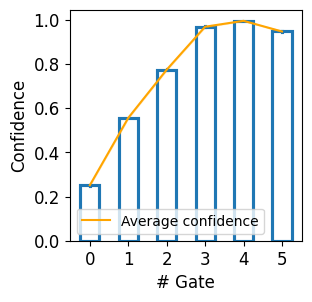

In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 56
height = 56
model = 'resnet'
dataset = 'imagenet'
import numpy as np

client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# number of test
resnet_imagenet_conf_vs_gate = np.zeros((len(middle_size_resnet), len(test)))

with torch.no_grad():
    count = 0
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        client_out = client(data).detach()
        
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(client_out)
           
            gate_out = gate_models[j](middle_out)
            # add the gate out to the array
            resnet_imagenet_conf_vs_gate[j][count] = gate_out.cpu().numpy()

        count += data.shape[0]
# plot the seaborn
import seaborn as sns
# make the array to a pandas
import pandas as pd
import matplotlib.pyplot as plt
pd_resnet_imagenet_conf_vs_gate = {'gate':[], 'conf':[]}
for i in range(resnet_imagenet_conf_vs_gate.shape[0]):
    for j in range(resnet_imagenet_conf_vs_gate.shape[1]):
        pd_resnet_imagenet_conf_vs_gate['gate'].append(i)
        pd_resnet_imagenet_conf_vs_gate['conf'].append(resnet_imagenet_conf_vs_gate[i,j])
pd_resnet_imagenet_conf_vs_gate = pd.DataFrame(pd_resnet_imagenet_conf_vs_gate)
plt.figure(figsize=(3,3))
sns.barplot(data=pd_resnet_imagenet_conf_vs_gate, x='gate', y='conf', width=0.5, fill=False)
sns.lineplot(data=pd_resnet_imagenet_conf_vs_gate, x='gate', y='conf', color='orange', label = 'Average confidence')
plt.xlabel('# Gate', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
# plt.xticks(np.arange(len(middle_size_resnet.values())), [str(x) for x in middle_size_resnet.values()])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./Plots/resnet_imagenet_conf_vs_gate.pdf')

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_2124319/1926914691.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mobile_cifar_conf_vs_gate[j][count] = gate_out.cpu().numpy()
100%|██████████| 10000/10000 [00:22<00:00, 443.35it/s]


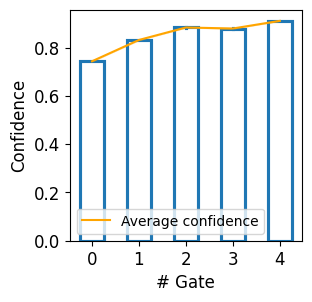

In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
model = 'mobile'
dataset = 'cifar-10'
import numpy as np

middle_size = middles_size[model]
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                        weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size[i])
    middle.load_state_dict(torch.load('./Weights/cifar-10/middle/mobile_cifar-10_middle_%s.pth'%str(middle_size[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size)):
    gate = gatedmodel.ExitGate(in_planes=middle_size[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# number of test
mobile_cifar_conf_vs_gate = np.zeros((len(middle_size), len(test)))

with torch.no_grad():
    count = 0
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        client_out = client(data).detach()
        
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(client_out)
           
            gate_out = gate_models[j](middle_out)
            # add the gate out to the array
            mobile_cifar_conf_vs_gate[j][count] = gate_out.cpu().numpy()

        count += data.shape[0]
# plot the seaborn
import seaborn as sns
# make the array to a pandas
import pandas as pd
import matplotlib.pyplot as plt
pd_mobile_cifar_conf_vs_gate = {'gate':[], 'conf':[]}
for i in range(mobile_cifar_conf_vs_gate.shape[0]):
    for j in range(mobile_cifar_conf_vs_gate.shape[1]):
        pd_mobile_cifar_conf_vs_gate['gate'].append(i)
        pd_mobile_cifar_conf_vs_gate['conf'].append(mobile_cifar_conf_vs_gate[i,j])
pd_mobile_cifar_conf_vs_gate = pd.DataFrame(pd_mobile_cifar_conf_vs_gate)
plt.figure(figsize=(3,3))
sns.barplot(data=pd_mobile_cifar_conf_vs_gate, x='gate', y='conf', width=0.5, fill=False)
sns.lineplot(data=pd_mobile_cifar_conf_vs_gate, x='gate', y='conf', color='orange', label = 'Average confidence')
plt.xlabel('# Gate', fontsize=12)
# plt.xticks(np.arange(len(middle_size.values())), [str(x) for x in middle_size.values()])
plt.xticks(fontsize=12)
plt.ylabel('Confidence', fontsize=12)
# plt.xticks(np.arange(len(middle_size.values())), [str(x) for x in middle_size.values()])
plt.yticks(fontsize=12)
plt.savefig('./Plots/mobile_cifar_conf_vs_gate.pdf')

In [ ]:
print(np.arange(len(middle_size.values())), [str(x) for x in middle_size.values()])

[0 1 2 3 4] ['1', '2', '4', '8', '16']


In [ ]:
# latency data

mc_client_lat = '3.011250496	2.916940053	3.165527185	3.089086215	5.275074641	3.069484234	3.218305111	3.622289499	3.157031536	3.226836522'.split('\t')
mc_LTE_lat = '91.7512	104.3535	91.4594	90.8706	99.3892	90.3029	91.545	104.4354	91.3867	99.8829'.split('\t')
mc_wifi_lat = '6.4353	6.8067	6.7457	6.389	6.7314	5.3041	7.2176	6.6298	6.1017	5.8227'.split('\t')
mc_server_lat = '5.2649	3.0527	3.2189	3.5748	3.0986	3.2618	3.383	3.2862	3.0711	3.1564'.split('\t')
mc_acc = '0.8333	0.8667	0.7833	0.8333	0.8	0.8167	0.85	0.8167	0.85	0.9'.split('\t')
mc_gate_frequency = [0, 146, 431, 20, 3, 0]

mc_jpeg25_lat = '0.05048116048	0.04309018453	0.04274050395	0.04312594732	0.04289944967	0.04320144653	0.04414717356	0.04554589589	0.04257361094	0.04267692566'.split('\t')
mc_jpeg75_lat = '0.04540284475	0.04580815633	0.04723866781	0.04511674245	0.04590352376	0.04342397054	0.0461935997	0.04468361537	0.04683732986	0.0527381897'.split('\t')
mc_cjpeg_lat = '0.0129143397	0.01225511233	0.01269380252	0.01238147418	0.0126850605	0.01259485881	0.01263777415	0.01261711121	0.01216252645	0.01242001851'.split('\t')
mc_jpeg25_LTE_lat ='91.1441	90.6561	108.808	92.3479	99.6863	106.982	93.6676	88.9866	92.3934	90.7556'.split('\t')
mc_jpeg75_LTE_lat ='89.0056	93.536	103.7565	89.9081	94.9797	99.6373	90.5789	96.2237	104.4482	96.0478'.split('\t')
mc_cjpeg_LTE_lat ='68.3318	62.8665	67.8649	55.6286	58.1947	59.7911	52.9546	53.4926	61.6087	64.6188'.split('\t')

mc_jpeg25_wifi_lat ='7.231048743	7.199851672	6.700519721	6.800436974	6.116072337	5.950073401	5.262315273	6.651310126	7.051165899	7.098738352'.split('\t')
mc_jpeg75_wifi_lat ='7.203467687	6.804585457	6.476048628	6.09412988	6.142528852	5.391164621	6.968196233	6.921831767	6.482613087	6.579184532'.split('\t')
mc_cjpeg_wifi_lat ='9.443529447	7.188586394	7.509156068	9.11902984	8.671979109	7.015939554	8.006838957	8.804400762	8.707586924	8.856360118'.split('\t')

mc_jpeg25_server_lat ='3.635370731	3.594056765	3.534579277	3.552341461	3.596754869	3.623759747	3.498621782	3.618709246	3.58213981	3.490730127'.split('\t')
mc_jpeg75_server_lat ='3.335189819	3.513403734	3.528730075	3.33998998	3.288976351	3.277496497	3.330787023	3.343451023	3.365174929	3.373257319'.split('\t')
mc_cjpeg_server_lat ='3.300317128	3.437165419	3.421398004	3.30675443	3.404005369	3.368230661	3.462179502	3.341809909	3.330520789	3.379420439'.split('\t')

mc_jpeg25_server_acc ='0.65	0.7	0.6333333333	0.6833333333	0.65	0.7	0.7166666667	0.6666666667	0.7666666667	0.7166666667'.split('\t')
mc_jpeg75_server_acc ='0.8	0.8666666667	0.7666666667	0.7833333333	0.7166666667	0.7666666667	0.8333333333	0.7666666667	0.9	0.8833333333'.split('\t')
mc_cjpeg_server_acc ='0.8166666667	0.8	0.7666666667	0.8166666667	0.7166666667	0.8	0.8333333333	0.7833333333	0.8666666667	0.8666666667'.split('\t')

# --------------------------------
ri_client_lat = '63.56255611	60.68547567	60.39473613	60.08947293	60.36367416	63.79266977	64.21508392	60.54291725	63.72853518	67.84100533'.split('\t')
ri_LTE_lat = '63.7469	56.0862	54.0241	46.9759	47.9522	60.9187	81.634	64.7588	53.382	66.7253'.split('\t')
ri_wifi_lat = '8.612211545	8.906888962	9.106779099	9.018425147	8.544460932	9.359649817	9.559373061	8.523921172	9.874848525	8.4522446'.split('\t')
ri_server_lat = '3.4139	3.3888	3.402	3.477	3.4073	3.3982	3.3837	3.3911	3.3917	3.4164'.split('\t')
ri_acc = '0.7667	0.7167	0.8667	0.7333	0.7333	0.75	0.8667	0.7833	0.8	0.85'.split('\t')
ri_gate_frequency = [0, 6, 45, 492, 56, 1, 0]

ri_jpeg25_lat = '1.741532485	1.385676861	1.439289252	1.561021805	1.5949289	1.391688983	1.759064198	1.275142034	1.470804214	1.317465305'.split('\t')
ri_jpeg75_lat = '1.591479778	1.583699385	1.634943485	1.759318511	1.823759079	1.577766736	1.997041702	1.459431648	1.65661176	1.49667263'.split('\t')
ri_cjpeg_lat = '1.072545449	1.10306104	1.065321763	1.14809076	1.169765393	1.026557684	1.26452446	1.008483171	1.107932329	0.9683740139'.split('\t')
ri_jpeg25_LTE_lat ='114.8201	53.3138	68.3162	62.7739	56.9511	51.3829	50.3428	49.8037	50.4194	67.5383'.split('\t')
ri_jpeg75_LTE_lat ='83.6933	64.6657	98.0106	79.8779	65.8071	72.2258	206.2906	196.9946	78.9902	124.6065'.split('\t')
ri_cjpeg_LTE_lat ='132.9265	96.1997	117.8552	176.8647	141.4235	174.5994	96.3187	259.097	256.838	212.6437'.split('\t')

ri_jpeg25_wifi_lat ='10.24499734	8.606231213	8.281028271	9.341367086	9.371987979	8.401608467	9.570153554	9.548381964	9.556833903	8.62335364'.split('\t')
ri_jpeg75_wifi_lat ='8.839941025	8.316572507	8.684921265	8.977170785	8.614699046	9.285835425	8.167767525	9.196285407	8.480258783	9.120563666'.split('\t')
ri_cjpeg_wifi_lat ='9.913372993	8.792376518	8.909348647	8.943716685	9.421622753	8.838915825	9.11757946	9.424217542	8.652635415	9.005987644'.split('\t')

ri_jpeg25_server_lat ='5.312	4.9395	5.2042	5.2532	5.6307	5.4263	5.544	5.6886	5.0294	5.3301'.split('\t')
ri_jpeg75_server_lat ='5.7784	5.3921	5.6901	5.6746	5.697	5.4954	5.7028	5.9074	5.7537	5.5621'.split('\t')
ri_cjpeg_server_lat ='7.1461	6.7674	7.1299	7.2767	7.5804	7.4747	7.6563	8.4955	7.1995	7.4197'.split('\t')

ri_jpeg25_server_acc ='0.7	0.6667	0.7333	0.6667	0.7333	0.7333	0.7667	0.7167	0.75	0.8167'.split('\t')
ri_jpeg75_server_acc ='0.7333	0.7333	0.75	0.7833	0.7833	0.85	0.9	0.8	0.8	0.8833'.split('\t')
ri_cjpeg_server_acc ='0.7667	0.7667	0.7833	0.8	0.8667	0.8333	0.9167	0.8167	0.7833	0.85'.split('\t')

ri_server_acc = '0.7833333333	0.7333333333	0.75	0.8	0.8666666667	0.8666666667	0.9166666667	0.8	0.8	0.8833333333'.split('\t')


In [ ]:
pd_latency = {'dataset':[], 'model':[], 'part':[], 'type':[], 'data':[]}
for i in range(10):
    for j in range (5):
        pd_latency['dataset'].append('cifar')
        pd_latency['model'].append('mobile')
    pd_latency['part'].append('client')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(mc_client_lat[i])

    pd_latency['part'].append('LTE')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(mc_LTE_lat[i])

    pd_latency['part'].append('wifi')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(mc_wifi_lat[i])

    pd_latency['part'].append('server')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(mc_server_lat[i])

    pd_latency['part'].append('pretrained')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(mc_acc[i])

for i in range(10):
    for j in range (5):
        pd_latency['dataset'].append('cifar')
        pd_latency['model'].append('mobile')

    pd_latency['part'].append('client')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(ri_client_lat[i])

    pd_latency['part'].append('LTE')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(ri_LTE_lat[i])

    pd_latency['part'].append('wifi')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(ri_wifi_lat[i])

    pd_latency['part'].append('server')
    pd_latency['type'].append('lat')
    pd_latency['data'].append(ri_server_lat[i])

    pd_latency['part'].append('pretrained')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(ri_acc[i])

for i in range (10):
    for part in ['client', 'LTE', 'wifi', 'server']:
        pd_latency['dataset'].append('cifar')
        pd_latency['model'].append('JPEG25')
        pd_latency['part'].append(part)
        pd_latency['type'].append('lat')
        pd_latency['data'].append(mc_jpeg25_lat[i])

    for part in ['client', 'LTE', 'wifi', 'server']:
        pd_latency['dataset'].append('cifar')
        pd_latency['model'].append('JPEG75')
        pd_latency['part'].append(part)
        pd_latency['type'].append('lat')
        pd_latency['data'].append(mc_jpeg75_lat[i])

    for part in ['client', 'LTE', 'wifi', 'server']:
        pd_latency['dataset'].append('cifar')
        pd_latency['model'].append('CJPEG')
        pd_latency['part'].append(part)
        pd_latency['type'].append('lat')
        pd_latency['data'].append(mc_cjpeg_lat[i])

    for part in ['client', 'LTE', 'wifi', 'server']:
        pd_latency['dataset'].append('imagenet')
        pd_latency['model'].append('JPEG25')
        pd_latency['part'].append(part)
        pd_latency['type'].append('lat')
        pd_latency['data'].append(ri_jpeg25_lat[i])

    for part in ['client', 'LTE', 'wifi', 'server']:
        pd_latency['dataset'].append('imagenet')
        pd_latency['model'].append('JPEG75')
        pd_latency['part'].append(part)
        pd_latency['type'].append('lat')
        pd_latency['data'].append(ri_jpeg75_lat[i])

    for part in ['client', 'LTE', 'wifi', 'server']:
        pd_latency['dataset'].append('imagenet')
        pd_latency['model'].append('CJPEG')
        pd_latency['part'].append(part)
        pd_latency['type'].append('lat')
        pd_latency['data'].append(ri_cjpeg_lat[i])

for i in range (10):
    pd_latency['dataset'].append('cifar')
    pd_latency['model'].append('CJPEG')
    pd_latency['part'].append('server')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(mc_cjpeg_server_acc[i])

    pd_latency['dataset'].append('imagenet')
    pd_latency['model'].append('JPEG25')
    pd_latency['part'].append('server')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(ri_jpeg25_server_acc[i])

    pd_latency['dataset'].append('imagenet')
    pd_latency['model'].append('JPEG75')
    pd_latency['part'].append('server')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(ri_jpeg75_server_acc[i])

    pd_latency['dataset'].append('imagenet')
    pd_latency['model'].append('CJPEG')
    pd_latency['part'].append('server')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(ri_cjpeg_server_acc[i])

    pd_latency['dataset'].append('cifar')
    pd_latency['model'].append('JPEG25')
    pd_latency['part'].append('server')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(mc_jpeg25_server_acc[i])
    
    pd_latency['dataset'].append('imagenet')
    pd_latency['model'].append('JPEG75')
    pd_latency['part'].append('server')
    pd_latency['type'].append('acc')
    pd_latency['data'].append(mc_jpeg75_server_acc[i])

pd_latency = pd.DataFrame(pd_latency)
print(pd_latency)


      dataset   model        part type          data
0       cifar  mobile      client  lat   3.011250496
1       cifar  mobile         LTE  lat       91.7512
2       cifar  mobile        wifi  lat        6.4353
3       cifar  mobile      server  lat        5.2649
4       cifar  mobile  pretrained  acc        0.8333
..        ...     ...         ...  ...           ...
395  imagenet  JPEG25      server  acc        0.8167
396  imagenet  JPEG75      server  acc        0.8833
397  imagenet   CJPEG      server  acc          0.85
398     cifar  JPEG25      server  acc  0.7166666667
399  imagenet  JPEG75      server  acc  0.8833333333

[400 rows x 5 columns]


In [ ]:
# plot the accuracy 



Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:59<00:00, 167.16it/s]


Accuracy: [0.8486]


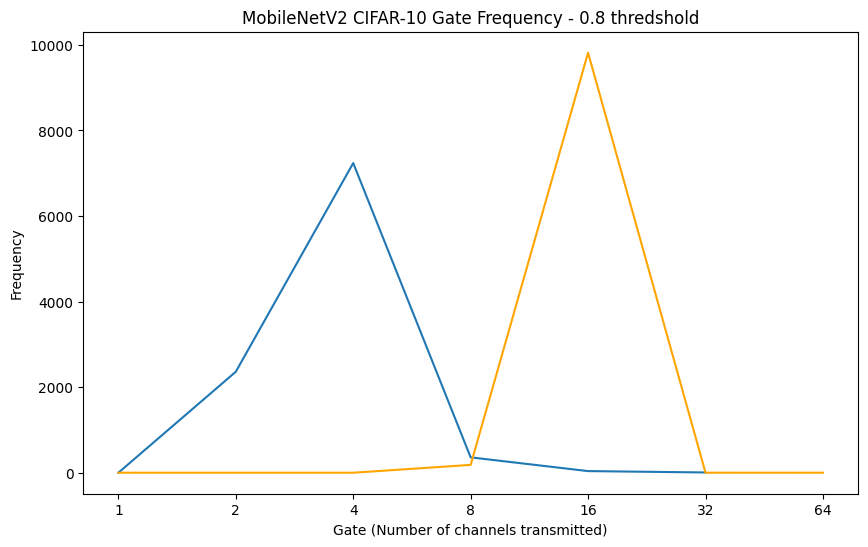

In [ ]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.85
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_080 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_080 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_080[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_080[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_080 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_080)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - 0.8 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# --------


width = 8
height = 8

client, server = resnet.resnet_splitter(num_classes=10,weight_root='./Weights/cifar-10',layers=50)
middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('resnet_cifar-10_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/resnet_cifar-10_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
resnet_cifar_gate_frequency_080 = np.zeros(len(gate_models)+1)
resnet_cifar_gate_accuracy_080 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_cifar_gate_frequency_080[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_cifar_gate_frequency_080[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_cifar_gate_accuracy_080 += out.cpu().numpy()

# plot accuracy
print('Accuracy:', resnet_cifar_gate_accuracy_080/len(test))  
plt.plot([str(x) for x in middle_size_resnet.values()]+ [str(2*list(middle_size_resnet.values())[-1])], resnet_cifar_gate_frequency_080, color='orange')
plt.savefig('./Plots/cifar_gate_frequency_085.pdf')
plt.show()


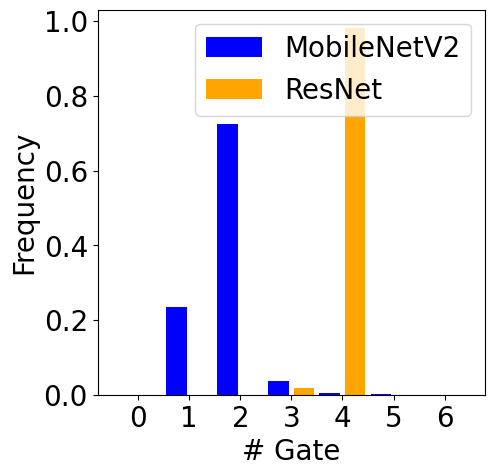

In [ ]:
# plot the bar using the data
import pandas as pd 

plt.figure(figsize=(5,5))
# ls1 = [x for x in mobile_cifar_gate_frequency_080/10000] + [0] 
# ls2 = [x for x in resnet_cifar_gate_frequency_080/10000] 
# ls3 = [x for x in range (7)]

# df = pd.DataFrame({'MobileNetV2':ls1, 'ResNet':ls2, 'gate':ls3})
# df.plot(kind='bar', x = 'gate', y = ['MobileNetV2', 'ResNet'], stacked=False) 
ls1 = [x for x in mobile_cifar_gate_frequency_080/10000] + [0] 
ls2 = [x for x in resnet_cifar_gate_frequency_080/10000]
x_axis = np.arange(len(ls2))

plt.bar(x_axis-0.25,ls1, color='b', label='MobileNetV2', width=0.4)
plt.bar(x_axis+0.25,ls2, color='orange', label='ResNet', width=0.4)
plt.xlabel('# Gate', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.savefig('./Plots/cifar_gate_frequency_085.pdf')

plt.show()

100%|██████████| 5087/5087 [00:43<00:00, 117.61it/s]


(6,)
(1,)


100%|██████████| 5087/5087 [00:43<00:00, 115.69it/s]


Accuracy: 0.0


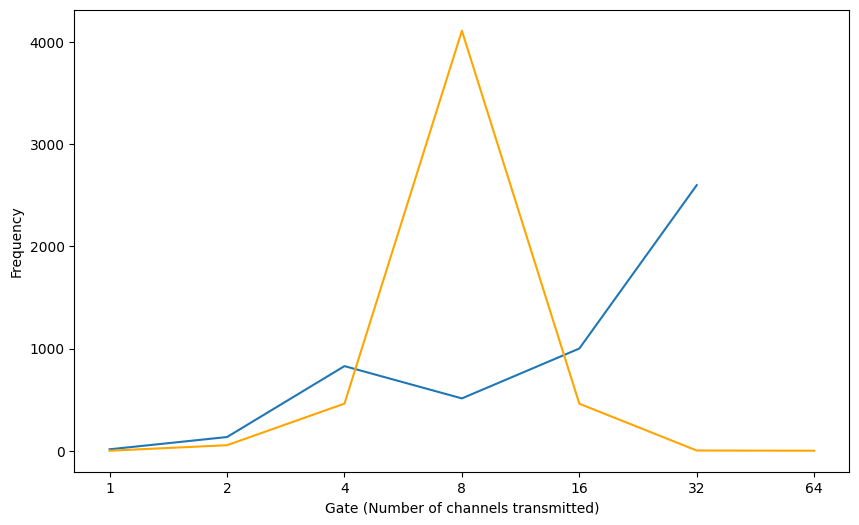

In [ ]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 112
height = 112
threshold = 0.85
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=1000,
                                                  weight_root='./Weights/imagenet')

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_imagenet_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/mobile_imagenet_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_imagenet_gate_frequency_085 = np.zeros(len(gate_models)+1)
mobile_imagenet_gate_accuracy_085 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_imagenet_gate_frequency_085[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_imagenet_gate_frequency_085[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_imagenet_gate_accuracy_085 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
print(mobile_imagenet_gate_frequency_085.shape)
print(mobile_imagenet_gate_accuracy_085.shape)
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_imagenet_gate_frequency_085)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# --------


width = 56
height = 56

client, server = resnet.resnet_splitter(num_classes=1000,weight_root='./Weights/imagenet',layers=50)
middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
resnet_imagenet_gate_frequency_085 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_085 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_085[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_085[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_085 += out.cpu().numpy()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_080/len(test))  
plt.plot([str(x) for x in middle_size_resnet.values()]+ [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_085, color='orange')
plt.savefig('./Plots/imagenet_gate_frequency_085.pdf')
plt.show()


[0.0014, 0.0134, 0.0828, 0.0512, 0.1, 0.2599, 0]
[0.0, 0.0054, 0.0461, 0.411, 0.046, 0.0002, 0.0]
[0 1 2 3 4 5 6]


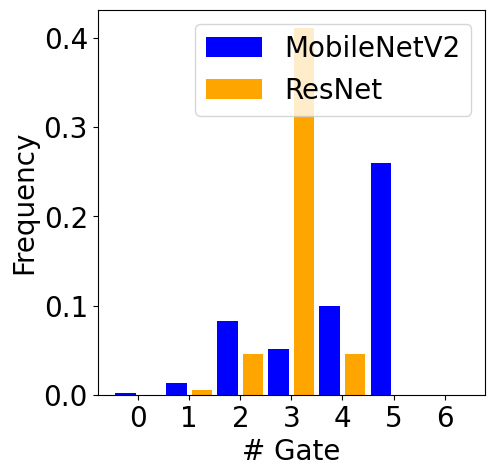

In [ ]:
# plot the bar using the data
import pandas as pd 

plt.figure(figsize=(5,5))
# ls1 = [x for x in mobile_cifar_gate_frequency_080/10000] + [0] 
# ls2 = [x for x in resnet_cifar_gate_frequency_080/10000] 
# ls3 = [x for x in range (7)]

# df = pd.DataFrame({'MobileNetV2':ls1, 'ResNet':ls2, 'gate':ls3})

# df.plot(kind='bar', x = 'gate', y = ['MobileNetV2', 'ResNet'], stacked=False) 
ls1 = [x for x in mobile_imagenet_gate_frequency_085/10000] + [0] 
ls2 = [x for x in resnet_imagenet_gate_frequency_085/10000]
x_axis = np.arange(len(ls2))
print(ls1)
print(ls2)
print(x_axis)
plt.bar(x_axis-0.25,ls1, color='b', label='MobileNetV2', width=0.4)
plt.bar(x_axis+0.25,ls2, color='orange', label='ResNet', width=0.4)
plt.xlabel('# Gate', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.locator_params(axis='y', nbins=5)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)
plt.savefig('./Plots/imagenet_gate_frequency_085.pdf')
plt.show()

In [ ]:
# show the number of parameters in gates and middle layers
import torchsummary 
mobile_gate_encoder_size = 0
mobile_decoder_size = 0
for i in range(len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=16, height=16)
    mobile_gate_encoder_size += sum(p.numel() for p in middle.in_layer.parameters())
    mobile_gate_encoder_size += sum(p.numel() for p in gate.parameters())
    mobile_decoder_size += sum(p.numel() for p in middle.out_layer.parameters())
print('MobileNetV2 Encoder Size:', mobile_gate_encoder_size)
print('MobileNetV2 Decoder Size:', mobile_decoder_size)

mobile_gate_encoder_size = 0
mobile_decoder_size = 0
for i in range(len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=112, height=112)
    mobile_gate_encoder_size += sum(p.numel() for p in middle.in_layer.parameters())
    mobile_gate_encoder_size += sum(p.numel() for p in gate.parameters())
    mobile_decoder_size += sum(p.numel() for p in middle.out_layer.parameters())
print('MobileNetV2 Encoder Size:', mobile_gate_encoder_size)
print('MobileNetV2 Decoder Size:', mobile_decoder_size)

resnet_gate_encoder_size = 0
resnet_decoder_size = 0
for i in range(len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=8, height=8)
    resnet_gate_encoder_size += sum(p.numel() for p in middle.in_layer.parameters())
    resnet_gate_encoder_size += sum(p.numel() for p in gate.parameters())
    resnet_decoder_size += sum(p.numel() for p in middle.out_layer.parameters())
print('ResNet Encoder Size:', resnet_gate_encoder_size)
print('ResNet Decoder Size:', resnet_decoder_size)

resnet_gate_encoder_size = 0
resnet_decoder_size = 0
for i in range(len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=56, height=56)
    resnet_gate_encoder_size += sum(p.numel() for p in middle.in_layer.parameters())
    resnet_gate_encoder_size += sum(p.numel() for p in gate.parameters())
    resnet_decoder_size += sum(p.numel() for p in middle.out_layer.parameters())
print('ResNet Encoder Size:', resnet_gate_encoder_size)
print('ResNet Decoder Size:', resnet_decoder_size)
    
# mobilenetV2 and resnet parameters
from Models import mobilenetv2
from Models import resnet
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='./Weights/cifar-10')
client_p = sum(p.numel() for p in client.parameters())
server_p = sum(p.numel() for p in server.parameters())
print('MobileNetV2 CIFAR-10 Client Parameters:', client_p)
print('MobileNetV2 CIFAR-10 Server Parameters:', server_p)

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=1000, weight_root='./Weights/imagenet')
client_p = sum(p.numel() for p in client.parameters())
server_p = sum(p.numel() for p in server.parameters())
print('MobileNetV2 ImageNet Client Parameters:', client_p)
print('MobileNetV2 ImageNet Server Parameters:', server_p)

client, server = resnet.resnet_splitter(num_classes=10, weight_root='./Weights/cifar-10', layers=50)
client_p = sum(p.numel() for p in client.parameters())
server_p = sum(p.numel() for p in server.parameters())

print('ResNet CIFAR-10 Client Parameters:', client_p)
print('ResNet CIFAR-10 Server Parameters:', server_p)

client, server = resnet.resnet_splitter(num_classes=1000, weight_root='./Weights/imagenet', layers=50)
client_p = sum(p.numel() for p in client.parameters())
server_p = sum(p.numel() for p in server.parameters())
print('ResNet ImageNet Client Parameters:', client_p)
print('ResNet ImageNet Server Parameters:', server_p)


MobileNetV2 Encoder Size: 12321
MobileNetV2 Decoder Size: 9248
MobileNetV2 Encoder Size: 12321
MobileNetV2 Decoder Size: 9248
ResNet Encoder Size: 42114
ResNet Decoder Size: 37056
ResNet Encoder Size: 42114
ResNet Decoder Size: 37056
MobileNetV2 CIFAR-10 Client Parameters: 928
MobileNetV2 CIFAR-10 Server Parameters: 2235754
MobileNetV2 ImageNet Client Parameters: 928
MobileNetV2 ImageNet Server Parameters: 3503944
ResNet CIFAR-10 Client Parameters: 9536
ResNet CIFAR-10 Server Parameters: 23518986
ResNet ImageNet Client Parameters: 9536
ResNet ImageNet Server Parameters: 25547496


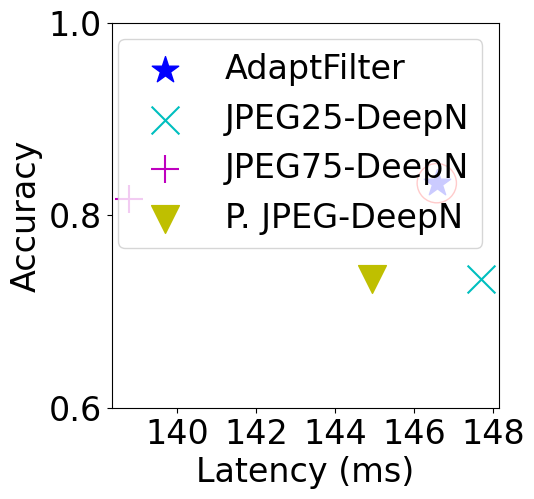

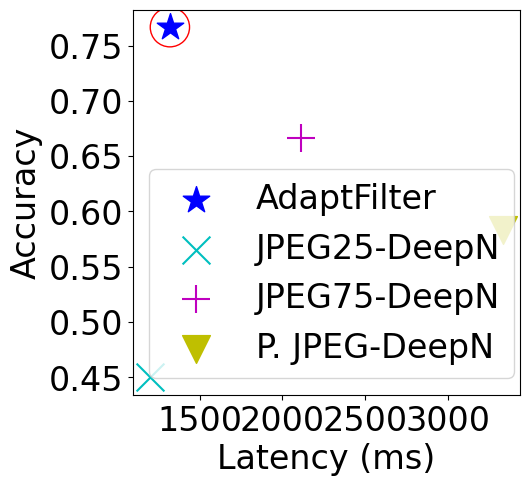

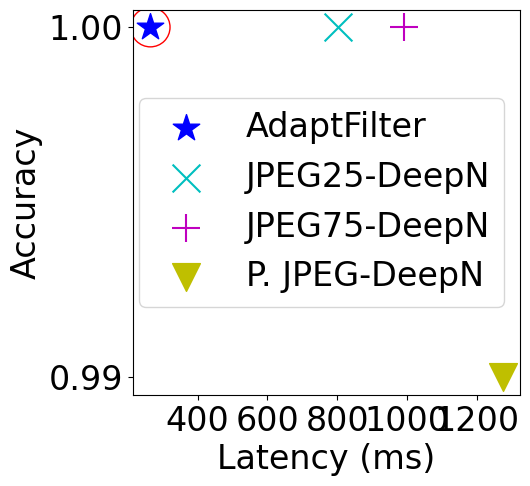

In [ ]:
l = [146.58,123.20,146.01,140.65,147.71,138.79,144.95]
a = [0.8333,0.65,0.8,0.8166666667,0.7333,0.8167,0.7333333333]
l2= [1321.01,744.91,1636.82,3321.27,1203.25,2113.09,3329.76]
a2= [0.7667,0.7,0.7333,0.7667,0.45,0.6667,0.5833]
l3 = [265.05,287.99,471.46,816.15, 802.37, 991.28, 1273.62]
a3 = [1, 1, 1,1,1,1, 0.99]

# plot 2d scatter plot
# use differnt color for different model
colors = ['b', 'orange', 'g', 'grey', 'c', 'm', 'y', 'k', 'w']
shape = ['*', 's', '^', 'D', 'x', '+', 'v', '<', '>']
labels = ['AdaptFilter', 'JPEG25', 'JPEG75', 'P. JPEG', 'JPEG25-DeepN', 'JPEG75-DeepN', 'P. JPEG-DeepN']
plt.figure(figsize=(5,5))
for i in range(7):
    if i ==1 or i ==2 or i == 3:
        continue
    plt.scatter(l[i], a[i], color=colors[i], marker=shape[i], label=labels[i], s=400)
plt.scatter(l[0], a[0], color=colors[3], marker='o', s=800, facecolors='none', edgecolors='r')
plt.xlabel('Latency (ms)', fontsize=24)
plt.ylabel('Accuracy', fontsize=24)
# plt.title('MobileNetV2 CIFAR-10')
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks([0.6, 0.8, 1],fontsize=24)
plt.savefig('./Plots/cifar_mobile_2d.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5,5))
for i in range(7):
    if i ==1 or i ==2 or i == 3:
        continue
    plt.scatter(l2[i], a2[i], color=colors[i], marker=shape[i], label=labels[i], s=400)
# plot a larget circle around the point
plt.scatter(l2[0], a2[0], color=colors[3], marker='o', s=800, facecolors='none', edgecolors='r')
plt.xlabel('Latency (ms)', fontsize=24)
plt.ylabel('Accuracy', fontsize=24)
# plt.title('MobileNetV2 CIFAR-10')
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig('./Plots/imagenet_resnet_2d.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(5,5))
for i in range(7):
    if i ==1 or i ==2 or i == 3:
        continue
    plt.scatter(l3[i], a3[i], color=colors[i], marker=shape[i], label=labels[i], s=400)
# plot a larget circle around the point
plt.scatter(l3[0], a3[0], color=colors[3], marker='o', s=800, facecolors='none', edgecolors='r')
plt.xlabel('Latency (ms)', fontsize=24)
plt.ylabel('Accuracy', fontsize=24)
# plt.title('MobileNetV2 CIFAR-10')
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks([0.99, 1],fontsize=24)
plt.savefig('./Plots/ccpd_resnet_2d.pdf',bbox_inches='tight')
plt.show()

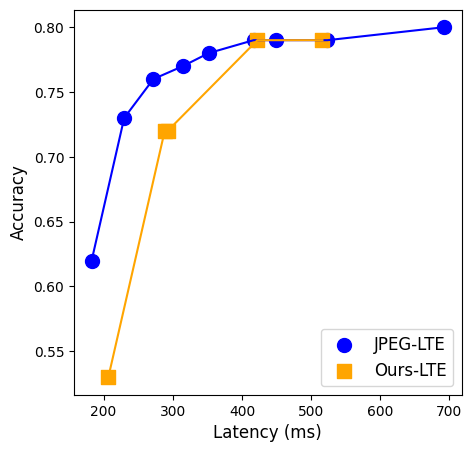

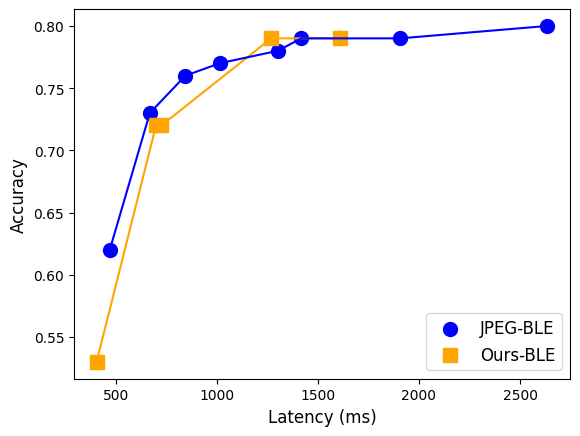

In [ ]:
jpeg_i = '10	20	30	40	50	60	70	80	90'.split('\t')
# str to int
jpeg_i = [int(x) for x in jpeg_i]
# jpeg_acc = '0.57	0.69	0.74	0.74	0.74	0.72	0.74	0.75	0.76'.split('\t')
jpeg_acc = '0.62	0.73	0.76	0.77	0.78	0.79	0.79	0.79	0.8'.split('\t')
jpeg_acc = [float(x) for x in jpeg_acc]
jpeg_s_lat = '3.82	3.51	3.52	3.45	3.51	3.54	3.57	3.67	3.42'.split('\t')
jpeg_s_lat = [float(x) for x in jpeg_s_lat]
jpeg_ble = '464.52	663.24	839.10	1,009.14	1,296.12	1,412.64	1,602.30	1,900.44	2,630.82'.split('\t')
jpeg_ble = [float(x.replace(',', '')) for x in jpeg_ble]
jpeg_ble = [float(x) for x in jpeg_ble]
jpeg_lte = '177.38	224.75	266.92	309.73	346.77	411.81	444.63	518.44	687.05'.split('\t')
jpeg_lte = [float(x) for x in jpeg_lte]
jpeg_c_lat = '1.5	1.5	1.5	1.5	1.5	1.5	1.5	1.5	1.5'.split('\t')
jpeg_c_lat = [float(x) for x in jpeg_c_lat]

our_i = '0.55	0.65	0.75	0.85	0.95'.split('\t')
out_i = [float(x) for x in our_i]
# our_acc = '0.53	0.7	0.71	0.75	0.74	0.74'.split('\t')
our_acc = '0.53	0.72	0.72	0.79	0.79'.split('\t')
our_acc = [float(x) for x in our_acc]
our_s_lat = '3.41	3.41	3.41	3.41	3.41'.split('\t')
our_s_lat = [float(x) for x in our_s_lat]
our_ble = '349.4	630.82	660.56	1190.81	1531.2'.split('\t')
our_ble = [float(x) for x in our_ble]
our_lte = '151.49	220.28	227.85	344.59	438.11'.split('\t')
our_lte = [float(x) for x in our_lte]
our_c_lat = '51.94	64.65	61.25	74.34	74.84'.split('\t')
our_c_lat = [float(x) for x in our_c_lat]

jpeg_lte_l = []
jpeg_ble_l = []
for i in range (9):
    jpeg_lte_l.append(jpeg_s_lat[i]+ jpeg_lte[i]+ jpeg_c_lat[i])
    jpeg_ble_l.append(jpeg_s_lat[i]+ jpeg_ble[i]+ jpeg_c_lat[i])

our_lte_l = []
our_ble_l = []
for i in range (5):
    our_lte_l.append(our_s_lat[i]+ our_lte[i]+ our_c_lat[i])
    our_ble_l.append(our_s_lat[i]+ our_ble[i]+ our_c_lat[i])

# plot line
plt.figure(figsize=(5,5))
plt.plot(jpeg_lte_l, jpeg_acc, color='b')
plt.scatter(jpeg_lte_l, jpeg_acc, color='b', marker='o', s=100, label='JPEG-LTE')

plt.plot(our_lte_l, our_acc, color='orange')
plt.scatter(our_lte_l, our_acc, color='orange', marker='s', s=100, label='Ours-LTE')
plt.xlabel('Latency (ms)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('./Plots/overall_acc_lat_LTE.pdf')
plt.show()
plt.figure(figsize=(5,5))
plt.plot(our_ble_l, our_acc, color='orange')
plt.scatter(jpeg_ble_l, jpeg_acc, color='b', marker='o', s=100, label='JPEG-BLE')
plt.plot(jpeg_ble_l, jpeg_acc, color='b')
plt.scatter(our_ble_l, our_acc, color='orange', marker='s', s=100, label='Ours-BLE')
plt.xlabel('Latency (ms)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('./Plots/overall_acc_lat_BLE.pdf')
plt.show()



Files already downloaded and verified
Files already downloaded and verified


 10%|█         | 1000/10000 [00:05<00:50, 177.72it/s]


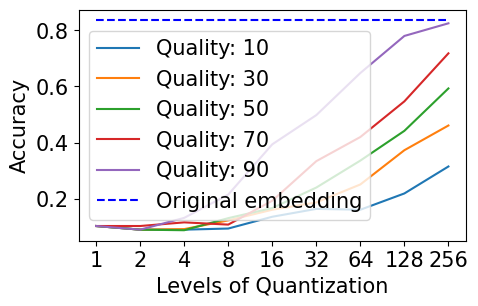

In [ ]:
# change the data type

# dataset = 'cifar10', model = mobile, accuracy vs data type
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
from Models import mobilenetv2
from Dataloaders import dataloader_cifar10
# get the number of zeros and positions
norm_acc = []
orig_acc = []

amp_list = [x for x in range(9)]

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')
client = client.eval()
server = server.eval()
client.to(device)
server.to(device)

orig_acc = 0
import cv2
quality_list = [10, 30, 50, 70, 90]
accuracy = np.zeros((len(amp_list), len(quality_list)))


for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    for j in range (len(amp_list)):

        client_out = client(data).detach() # 1, c', h, w

        amp = (2**j-1)

        client_out_max = torch.max(client_out)
        client_out_min = torch.min(client_out)
        client_out = (client_out-client_out_min)/(client_out_max-client_out_min)
        client_out = client_out*amp
        # change it to int
        client_out = client_out.int()

        for k in range(len(quality_list)):
            new_client_out = torch.zeros_like(client_out)
            for l in range (client_out.size(1)):
                img = client_out[0, l, :, :].cpu().numpy()
                img = img.astype(np.uint8)

                encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality_list[k]]
                result, encimg = cv2.imencode('.jpg', img, encode_param)

                img = cv2.imdecode(encimg, 1)
                # change it to greyscale
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                new_client_out[0, l, :, :] = torch.tensor(img)

            new_client_out = new_client_out.float()/amp
            new_client_out = new_client_out*(client_out_max-client_out_min)+client_out_min

            pred = server(new_client_out).detach()
            pred = torch.argmax(pred, dim=1)
            pred_acc = torch.sum(pred == label).item()
            accuracy[j,k] += pred_acc
    
    if i == 1000:
        break

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    client_out = client(data).detach() # 1, c', h, w

    pred = server(client_out).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()
    orig_acc += pred_acc

    if i == 1000:
        break
plt.figure(figsize=(5,3))
for i in range (len(quality_list)):
    plt.plot(amp_list, accuracy[:,i]/1000, label='Quality: %s'%quality_list[i])
plt.plot(amp_list, [orig_acc/1000]*len(amp_list), 'b--', label='Original embedding')
plt.xticks(amp_list, [2**x for x in amp_list], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Levels of Quantization',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=15)
# plt.title('Normalized and Original Different Amplitude: mobile cifar-10')
plt.savefig('./Plots/mobile_cifar-10_quant.pdf')
# plt.show()
# we can choose 64 and 128

In [ ]:
# change the data type

# dataset = 'cifar10', model = mobile, accuracy vs data type
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
from Models import mobilenetv2
from Dataloaders import dataloader_cifar10
# get the number of zeros and positions
norm_acc = []
orig_acc = []

amp = 255

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')
client = client.eval()
server = server.eval()
device = 'cuda:0'
client.to(device)
server.to(device)

orig_acc = 0
orig_size = 0
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
quality_list = [5*x for x in range(1, 21)]
accuracy = np.zeros(len(quality_list))
size = np.zeros(len(quality_list))


# for i, (data, label) in enumerate(tqdm(test)):
#     data, label = data.to(device), label.to(device)

#     client_out = client(data).detach() # 1, c', h, w

#     client_out_max = torch.max(client_out)
#     client_out_min = torch.min(client_out)
#     client_out = (client_out-client_out_min)/(client_out_max-client_out_min)
#     client_out = client_out*amp
#     # change it to int
#     client_out = client_out.int()

#     for k in range(len(quality_list)):
#         new_client_out = torch.zeros_like(client_out)
#         for l in range (client_out.size(1)):
#             img = client_out[0, l, :, :].cpu().numpy()

#             encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality_list[k]]
#             result, encimg = cv2.imencode('.jpg', img, encode_param)
#             size[k] += sys.getsizeof(encimg)
#             print(sys.getsizeof(encimg))

#             img = cv2.imdecode(encimg, 0)
#             # change it to greyscale
#             new_client_out[0, l, :, :] = torch.tensor(img)
#             # sys.exit()

#         new_client_out = new_client_out.float()/amp
#         new_client_out = new_client_out*(client_out_max-client_out_min)+client_out_min

#         pred = server(new_client_out).detach()
#         pred = torch.argmax(pred, dim=1)
#         pred_acc = torch.sum(pred == label).item()
#         accuracy[k] += pred_acc
    
#     if i == 1000:
#         break

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    client_out = client(data).detach() # 1, c', h, w
    orig_size += sys.getsizeof(client_out.cpu().numpy())
    print(sys.getsizeof(client_out.cpu().numpy()))

    pred = server(client_out).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()
    orig_acc += pred_acc

    if i == 1000:
        break
plt.figure(figsize=(5,3))
for i in range (len(quality_list)):
    plt.scatter(quality_list[i], accuracy/1000)

plt.axhline(y=orig_acc/1000, color='b', linestyle='--', label='Original embedding')
plt.xlabel('JPEG Quality',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=15)
plt.show()
# we can choose 64 and 128

plt.figure(figsize=(5,3))
for i in range (len(quality_list)):
    plt.scatter(quality_list[i], size/1000)
plt.axhline(y=orig_size/1000, color='b', linestyle='--', label='Original embedding')
plt.xlabel('JPEG Quality',fontsize=15)
plt.ylabel('Size',fontsize=15)
plt.legend(fontsize=15)
plt.show()

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 14/10000 [00:00<02:09, 76.82it/s]

tensor([[[[0.3159, 0.4357, 0.3766,  ..., 0.4224, 0.3793, 0.3564],
          [0.3753, 0.4908, 0.5170,  ..., 0.4536, 0.5038, 0.4831],
          [0.4949, 0.4766, 0.4800,  ..., 0.3246, 0.5612, 0.4823],
          ...,
          [0.4739, 0.4713, 0.5937,  ..., 0.4527, 0.8048, 0.1834],
          [0.5634, 0.4863, 0.4589,  ..., 0.8412, 0.2333, 0.6502],
          [0.4144, 0.5213, 0.4905,  ..., 0.4212, 0.1734, 0.5293]],

         [[1.2831, 1.5524, 1.5245,  ..., 1.3702, 1.4141, 1.2655],
          [1.4754, 1.5997, 1.5593,  ..., 1.0142, 1.2912, 1.2264],
          [1.4290, 1.2179, 1.4381,  ..., 0.5564, 0.9801, 1.2063],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

  0%|          | 38/10000 [00:00<01:36, 103.24it/s]

tensor([[[[2.6963e-01, 5.0667e-01, 4.4837e-01,  ..., 5.0017e-01,
           7.5787e-01, 1.1775e+00],
          [4.6376e-01, 4.5171e-01, 3.5537e-01,  ..., 5.9504e-01,
           2.2803e-01, 3.3918e-01],
          [3.8895e-01, 5.0688e-01, 4.8917e-01,  ..., 4.9281e-01,
           0.0000e+00, 0.0000e+00],
          ...,
          [6.7312e-01, 5.6228e-01, 0.0000e+00,  ..., 1.1543e+00,
           8.3650e-01, 3.9361e-01],
          [5.5021e-01, 4.4619e-01, 6.3814e-01,  ..., 4.7598e-01,
           4.3213e-01, 4.3519e-01],
          [3.1298e-01, 4.9348e-01, 5.4104e-01,  ..., 4.6688e-01,
           4.4847e-01, 4.5810e-01]],

         [[2.4049e-01, 2.8427e-01, 2.6420e-01,  ..., 1.8935e-01,
           3.9176e-01, 6.2076e-01],
          [3.8048e-01, 2.4446e-01, 2.9221e-01,  ..., 7.3653e-01,
           8.5690e-01, 8.3957e-01],
          [4.6242e-01, 2.4871e-01, 3.9221e-01,  ..., 9.6891e-01,
           7.6773e-01, 5.2522e-01],
          ...,
          [6.7808e-01, 6.5099e-01, 2.3048e-01,  ..., 4.2366

  1%|          | 54/10000 [00:00<01:53, 87.80it/s] 

tensor([[[[0.0809, 0.4505, 0.4181,  ..., 0.4224, 0.6114, 0.4511],
          [0.5486, 0.4240, 0.5007,  ..., 0.5497, 0.4752, 0.5167],
          [0.5696, 0.5455, 0.4678,  ..., 0.5862, 0.4930, 0.5158],
          ...,
          [0.6371, 0.7258, 0.5729,  ..., 0.4341, 0.4401, 0.4402],
          [0.5939, 0.4120, 0.4777,  ..., 0.4788, 0.4132, 0.4436],
          [0.5091, 0.5794, 0.5408,  ..., 0.4423, 0.4577, 0.4895]],

         [[0.1815, 0.3156, 0.3587,  ..., 0.7780, 1.3402, 1.4393],
          [0.2339, 0.3679, 0.3767,  ..., 0.5270, 0.8992, 1.2561],
          [0.3226, 0.4417, 0.3773,  ..., 0.4944, 0.7606, 1.1327],
          ...,
          [0.6397, 0.7134, 0.6739,  ..., 0.3111, 0.1862, 0.1430],
          [0.8742, 0.8425, 0.8272,  ..., 0.3796, 0.2084, 0.1086],
          [0.9295, 0.8723, 0.8941,  ..., 0.3872, 0.2105, 0.0932]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3083, 0.1974, 0.2146,  ..., 0.0000, 0.0000, 0.0000],
          [0.2572, 0.1918, 0.1582,  ..., 0

KeyboardInterrupt: 

# More Plots

In [ ]:
# dataset = 'imagenet', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet')

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_imagenet_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
import sys
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target, _) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_mobile]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('MobileNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

Files already downloaded and verified
Files already downloaded and verified


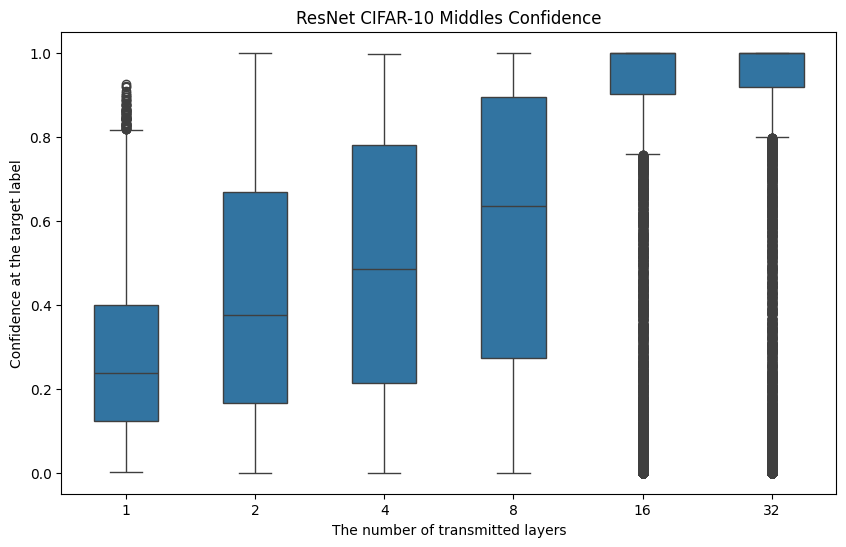

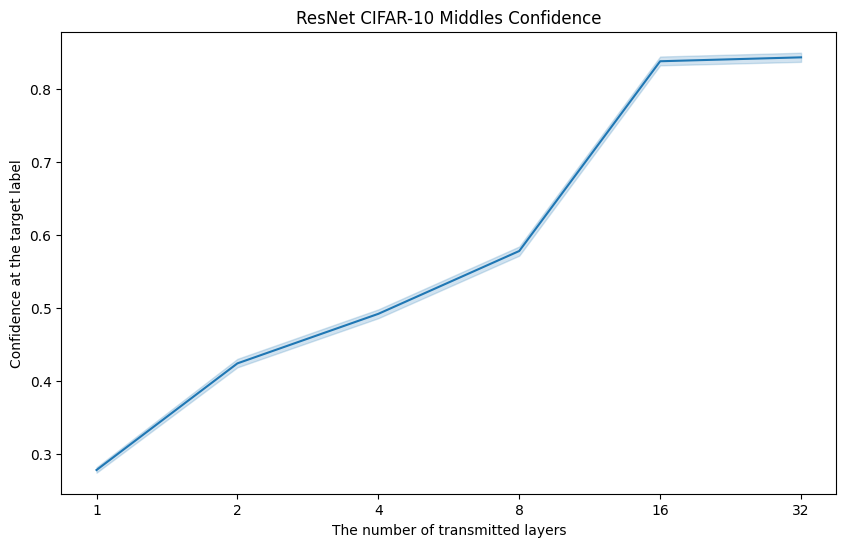

In [ ]:
# dataset = 'cifar10', model = resnet, CELoss vs middles
device = 'cuda:0'
client, server = resnet.resnet_splitter(num_classes=10,
                                        weight_root='./Weights/cifar-10',
                                        layers=50)

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('resnet_cifar-10_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_resnet]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))
middles_conf['conf'] = middles_conf['conf'].apply(lambda x: float(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('ResNet CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('ResNet CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.show()

In [ ]:
# dataset = 'imagenet', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet')

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()

middle_models = []
for i in range (1):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('/home/tonypeng/Downloads/mobile_imagenet_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
import sys
with torch.no_grad():
    # get the conf for each middles
    accuracy = [0] * len(middle_models)
    for i in range(len(middle_models)):
        count = 0
        for j, (data, targets) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = torch.argmax(out, dim=1)
            out = out.eq(target).float()
            count += out.shape[0]
            accuracy[i] += out.sum().item()
    # get the conf for the server   
        accuracy[i] /= count# print the accuracy    

print('MobileNetV2 Imagenet Middles Accuracy')
print('The number of transmitted layers', 'Accuracy')
for i in range(len(middle_models)):
    print(i, accuracy[i])

100%|██████████| 5087/5087 [00:47<00:00, 106.16it/s]


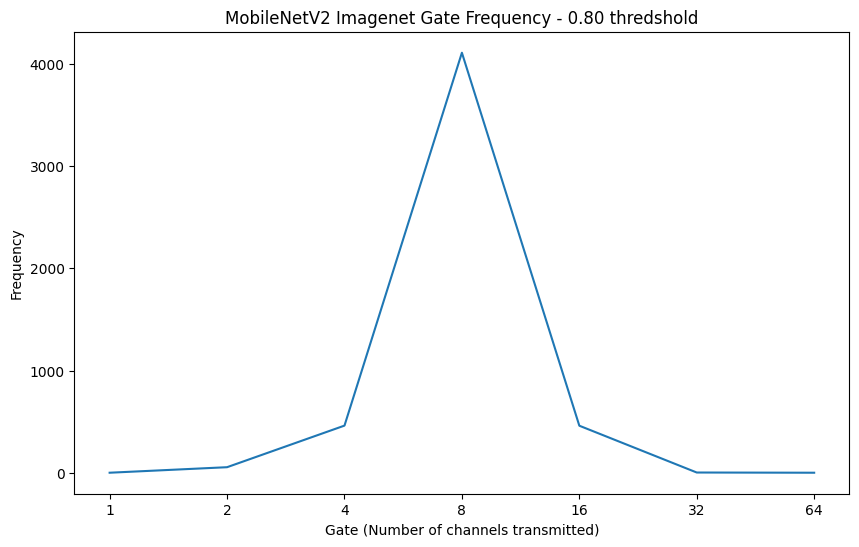

Accuracy: [0.82740318]


In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 56
height = 56
threshold = 0.85
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
resnet_imagenet_gate_frequency_085 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_085 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_085[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_085[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_085 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_085)
plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_085/len(test)) 


In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate


device = 'cuda:0'
width = 56
height = 56
threshold = 0.75
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
resnet_imagenet_gate_frequency_075 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_075 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_075[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_075[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_075 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_075)
plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_075/len(test)) 


In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
from Models import resnet
from Dataloaders import dataloader_image_20
device = 'cuda:0'
width = 56
height = 56
threshold = 0.8
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255

def normalize(x):
    x_min = torch.min(x)
    x_max = torch.max(x)
    return (x - x_min)/(x_max - x_min)

def normalize_return(x):
    x_min = torch.min(x)
    x_max = torch.max(x)
    return (x - x_min)/(x_max - x_min), x_min, x_max

def renormalize(x, x_min, x_max):
    return x * (x_max - x_min) + x_min

import torch
import numpy as np
resnet_imagenet_gate_frequency_080 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_080 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target, _) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        print(data[0,0,0])
        out = client(data).detach()
        print(out[0,0,0])
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_080[j] += 1

                middle_out1 = middle_out.clone()
                middle_out2 = middle_out.clone()
                
                middle_out, outmin, outmax = normalize_return(middle_out)
                # print(outmax, outmin)
                # print(middle_out[0,0,0])
                middle_out = float_to_uint(middle_out)
                
                # print(middle_out[0,0,0])
                middle_out = uint_to_float(middle_out)
                # print(middle_out[0,0,0])
                middle_out = renormalize(middle_out, outmin, outmax)
                # print(middle_out[0,0,0])

                middle_out1 = float_to_uint(middle_out1)
                middle_out1 = uint_to_float(middle_out1)

                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_080[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_080 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_080)
plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_080/len(test)) 


In [ ]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.85
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_085 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_085 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_085[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_085[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_085 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_085)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - 0.85 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

print('Accuracy:', mobile_cifar_gate_accuracy_085/len(test))

In [ ]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.75
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

mobile_cifar_gate_075 = [] # exit rate here
for i in range(len(gate_models)):
    mobile_cifar_gate_075.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_075 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_075 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_075[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_075[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_075 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_075)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - 0.75 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

print('Accuracy:', mobile_cifar_gate_accuracy_075/len(test))

In [ ]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.8
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_080 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_080 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_080[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_080[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_080 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_080)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - 0.8 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', mobile_cifar_gate_accuracy_080/len(test))  


In [ ]:
# dataset = 'imagenet', model = resnet, CELoss vs middles
from tqdm import tqdm
device = 'cuda:0'
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_resnet]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, fill=False, gap=.1, width=0.5, whis=(0, 100))
plt.title('ResNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.savefig('./Plots/resnet_imagenet_middle_conf.pdf')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('ResNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.show()

In [ ]:
# dataset = 'cifar10', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_mobile]
middles_conf['label'] = test.dataset.targets
middles_conf['label'] = middles_conf['label'].apply(lambda x: test.dataset.classes[x])
middles_conf = middles_conf.melt(id_vars='label', var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))
middles_conf['conf'] = middles_conf['conf'].apply(lambda x: float(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, fill=False, gap=.1, width=0.5, whis=(0, 100))
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.savefig('./Plots/mobile_cifar-10_middle_conf.pdf')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

In [ ]:
# dataset = 'cifar10', model = mobile, acc vs conf
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_mobile]
middles_conf['label'] = test.dataset.targets
middles_conf['label'] = middles_conf['label'].apply(lambda x: test.dataset.classes[x])
middles_conf = middles_conf.melt(id_vars='label', var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))
middles_conf['conf'] = middles_conf['conf'].apply(lambda x: float(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, fill=False, gap=.1, width=0.5, whis=(0, 100))
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.savefig('./Plots/mobile_cifar-10_middle_conf.pdf')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

90it [00:13,  6.54it/s]
90it [00:13,  6.80it/s]
90it [00:11,  7.68it/s]
90it [00:11,  7.83it/s]
90it [00:10,  8.25it/s]


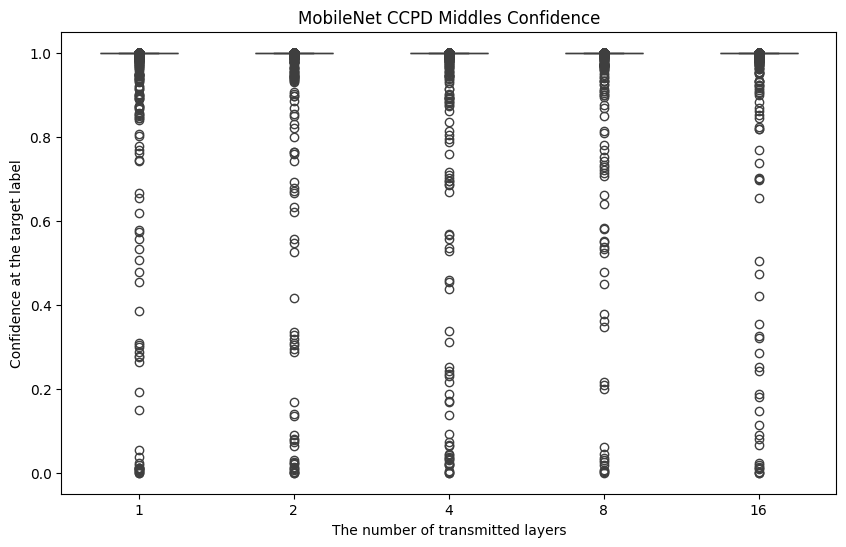

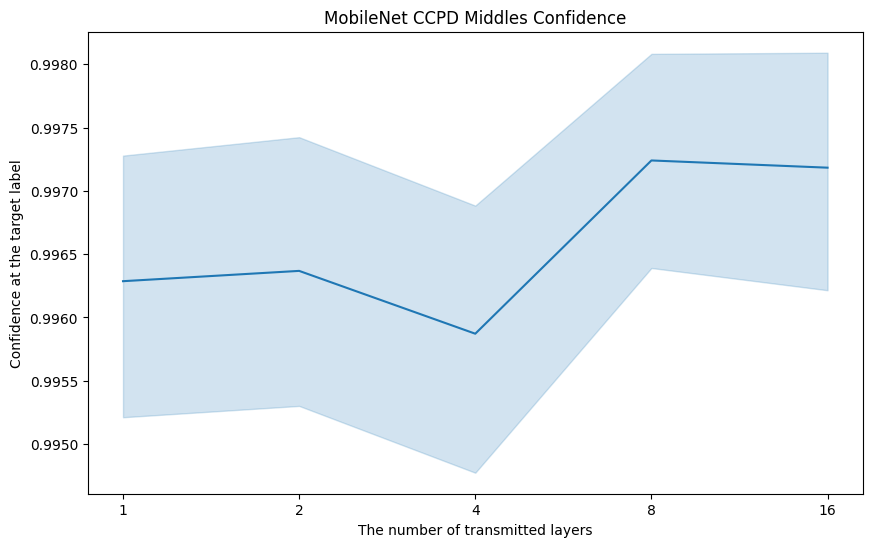

In [ ]:
# dataset = 'ccpd', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=34,
                                        weight_root='./Weights/ccpd-small/')

_, test, _ = dataloader_ccpd.Dataloader_ccpd_integrated()

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_ccpd_small_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
import sys
from tqdm import tqdm
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_mobile]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('MobileNet CCPD Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNet CCPD Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()